                         UAS Project Pengolahan Citra

          "Membuat Studi Kasus Menggunakan Tahapan Deep Learning 1-8"


Dataset Citra Kelompok Presentasi : (Judul "Klasifikasi Citra Makanan Burger dan Pizza  Menggunakan Model Vision Transformer(ViT)

Anggota Kelompok:

- Muhammad Dedi Setiawan (G.211.22.0086)

- Muhammad Rizal (G.211.22.0107)

- Bernandika Reyhan Groovytala (G.211.22.0109)



Tahap 1 - Import Library

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

Tahap 2: Akses Data (Mount Google Drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Tahap 3: Data Preparation

In [ ]:
#Transformasi Data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #standar ViT
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [ ]:
#Load Dataset
dataset = datasets.ImageFolder(
    root="/content/drive/MyDrive/Dataset Citra/Project/Dataset",
    transform=transform
)

class_names = dataset.classes
print(class_names)

['Burger', 'Pizza']


In [ ]:
#Split Data (Train & Validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Tahap 4:Model Architecture Selection & Model Construction

In [ ]:
#Load Pre-trained Vision Transformer
model = models.vit_b_16(pretrained=True)

#Ganti Classification Head Menjadi 2 Karena ada 2 kelas saja
num_features = model.heads.head.in_features
model.heads.head = nn.Linear(num_features, 2)

#Pindahkan Model ke Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:03<00:00, 95.4MB/s]


Tahap 5: Training Pipeline Setup

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Tahap 6: Training the Model

In [ ]:
#Inisialisasi Variabel untuk Logging
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
epochs = 5

for epoch in range(epochs):
    # TRAIN
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    #  VALIDATION
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

Epoch [1/5] Train Loss: 0.1840 | Train Acc: 92.62% Val Loss: 0.2938 | Val Acc: 91.00%
Epoch [2/5] Train Loss: 0.0878 | Train Acc: 97.50% Val Loss: 0.1585 | Val Acc: 94.00%
Epoch [3/5] Train Loss: 0.0078 | Train Acc: 99.75% Val Loss: 0.1027 | Val Acc: 97.50%
Epoch [4/5] Train Loss: 0.0155 | Train Acc: 99.62% Val Loss: 0.2949 | Val Acc: 89.00%
Epoch [5/5] Train Loss: 0.0915 | Train Acc: 96.38% Val Loss: 0.2864 | Val Acc: 91.50%


Tahap 7: Prediction

In [ ]:
from PIL import Image

def predict_multiple_images(model, image_paths, transform, class_names):
    model.eval()
    results = []

    with torch.no_grad():
        for path in image_paths:
            image = Image.open(path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0).to(device)

            outputs = model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()


            results.append((path, class_names[predicted_class], confidence, image))

    return results

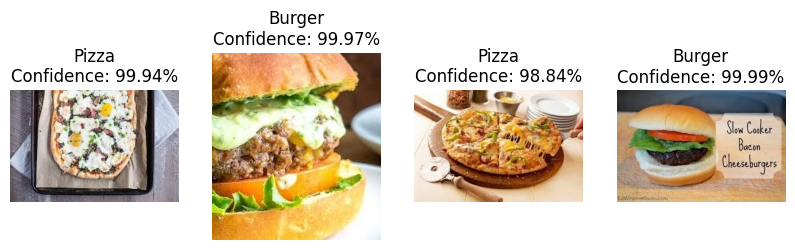

In [ ]:
 # Daftar path gambar uji
 image_paths = [
    "/content/drive/MyDrive/Dataset Citra/Project/Dataset/Pizza/Image_3010.jpg",
    "/content/drive/MyDrive/Dataset Citra/Project/Dataset/Burger/Image_20.jpg",
    "/content/drive/MyDrive/Dataset Citra/Project/Dataset/Pizza/Image_3015.jpg",
    "/content/drive/MyDrive/Dataset Citra/Project/Dataset/Burger/Image_15.jpg"
]

# Melakukan prediksi
results = predict_multiple_images(
    model,
    image_paths,
    transform,
    class_names
)

plt.figure(figsize=(10,5))

for i, (path, label, conf, img) in enumerate(results):
    plt.subplot(1, len(results), i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label}\nConfidence: {conf*100:.2f}%")

plt.show()

Tahap 8 :Evaluation

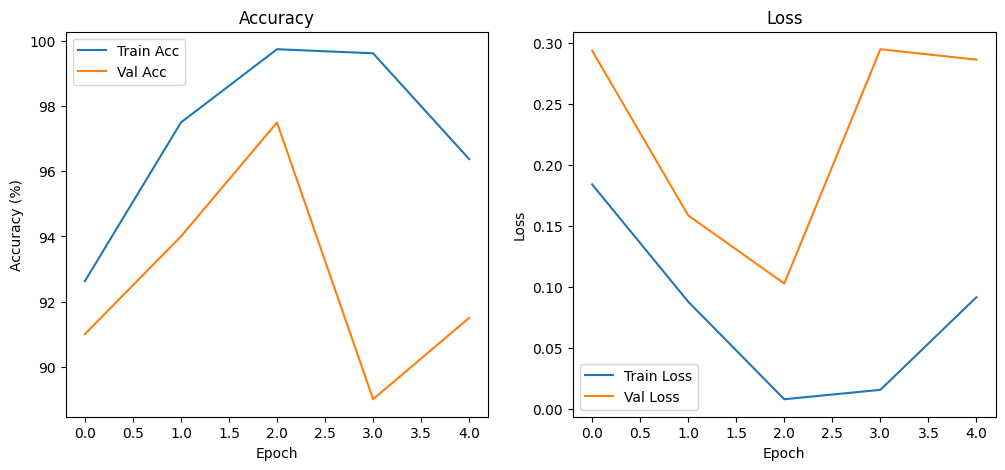

In [ ]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.eval()
correct = 0
total = 0
val_loss = 0.0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        # Hitung loss validasi
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Hitung akurasi
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Rata-rata validation loss
avg_val_loss = val_loss / len(val_loader)

accuracy = 100 * correct / total

print(f"Validation Loss    : {avg_val_loss:.2f}%")
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Loss    : 0.29%
Validation Accuracy: 91.50%


In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

<Figure size 500x500 with 0 Axes>

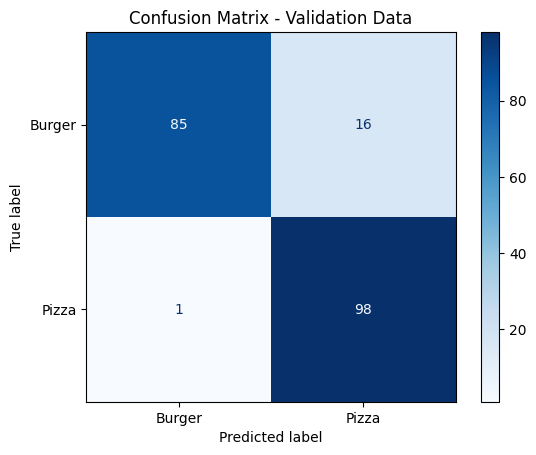

In [ ]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

plt.figure(figsize=(5,5))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Data")
plt.show()

In [ ]:
#Classification Report
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

              precision    recall  f1-score   support

      Burger       0.99      0.84      0.91       101
       Pizza       0.86      0.99      0.92        99

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200

